In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [4]:
g = torch.Generator().manual_seed(42) # reproducibility

In [5]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)

# building the dataset
block_size = 3  # context size: how many characters we consider to predict the next character

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # update context with the next character

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1]) # training set
Xdev, Ydev = build_dataset(words[n1:n2]) # validation set
Xte, Yte = build_dataset(words[n2:]) # test set

In [25]:
# Lets train a neural network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.Training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers - trained with running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)


    def __call__(self, x):
        # calculate the forward pass
        if self.Training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.Training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd = 10 # embedding size
n_hidden = 100 # hidden layer size
g = torch.Generator().manual_seed(2147483647) # reproducibility

C = torch.randn((vocab_size, n_embd), generator=g) # embedding matrix
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer, make less confident
    #layers[-1].weight *= 0.1
    # if last layer has batch norm, apply gain
    layers[-1].gamma *= 0.1

    # all other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'{sum(p.numel() for p in parameters)} parameters')
for p in parameters:
    p.requires_grad = True

47551 parameters


In [26]:
# Optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio (? grad:data ratio)

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # minibatch

    # forward pass
    emb = C[Xb] # embedding lookup
    x = emb.view(emb.shape[0], -1) # flatten the embedding
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss 

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # save the gradient of the output, for debugging
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad.data

    # track statistics
    if i % 10000 == 0: # every 10000 steps
        print(f'{i:7d}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters]) # 'update to data' ratio calculation, log10 for better visualization as it exponentiates the division.

    if i >= 1000:
        break # For Debugging

      0/200000: 3.3015


layer 2 (      Tanh): mean -0.00, std +0.63, saturated: +3.72%
layer 5 (      Tanh): mean -0.00, std +0.64, saturated: +2.47%
layer 8 (      Tanh): mean +0.00, std +0.64, saturated: +2.28%
layer 11 (      Tanh): mean +0.00, std +0.64, saturated: +2.25%
layer 14 (      Tanh): mean -0.00, std +0.65, saturated: +1.91%


Text(0.5, 1.0, 'Histograms of the activations')

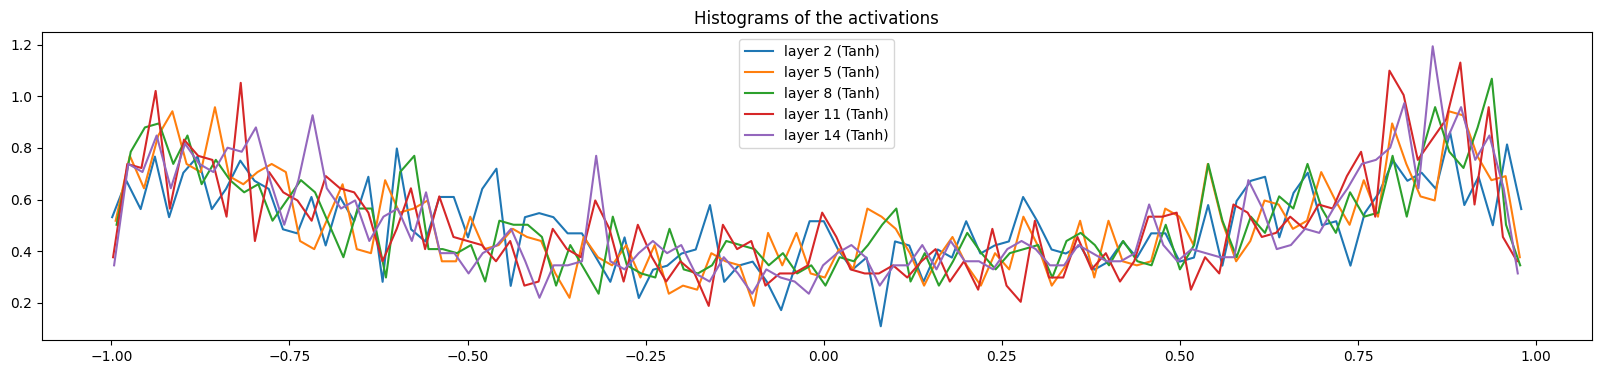

In [27]:
# In here we visualize the layers, specifically the tanh layers (1, 3, 5, 7, 9), as they are more controlable data to visualize, and we can see the mean, std, and the percentage of saturated neurons.
# Saturated here means how many neurons are close to -1 or 1, which is a sign of vanishing gradients i.e. mean of t.abs() is > .97
# what we observe with gain 5/3 is that the mean is close to 0, and the std is close to 1, and the percentage of saturated neurons is close to 0, which is a good sign. In the beginning
# saturation is 20 i.e bit high but it decreases with more number of layers.
# If we make gain as 2 for the linear layers, we observe that first layer is decent and remaining are shrinking to 0, which is a sign of vanishing gradients.
# IMPORTANT: Its important to understand that if it was alone linear layers, than sqaure root of fan_in above would have maintained the std to 1 and things would be good through all linear layers,
# but as we have tanh layers in between which keeps sqashing the distribution, we need to keep adding some gain like 5/3 to maintain the std to 1.

# Visualize the histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # ignore the last layer
    if isinstance(layer, Tanh): # only for tanh layer, as it is more controlable data to visualize
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %+.2f, saturated: %+.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histograms of the activations')

layer 2 (      Tanh): mean +0.000000, std 2.769027e-03
layer 5 (      Tanh): mean -0.000000, std 2.469570e-03
layer 8 (      Tanh): mean +0.000000, std 2.378182e-03
layer 11 (      Tanh): mean -0.000000, std 2.255722e-03
layer 14 (      Tanh): mean -0.000000, std 2.208439e-03


Text(0.5, 1.0, 'Histograms of the Gradient distributions')

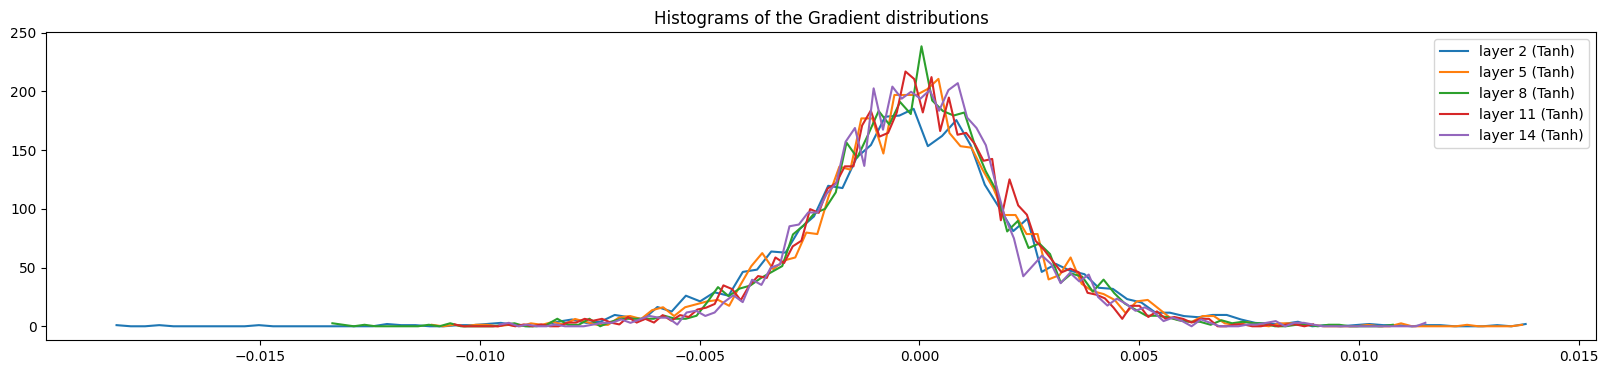

In [28]:
# Visualize the histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # ignore the last layer
    if isinstance(layer, Tanh): # only for tanh layer, as it is more controlable data to visualize
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histograms of the Gradient distributions')


# IMPORTANT: Important observation is that for each layer the gradients are not moving around, they are fairly consitent.

In [ ]:
# IMPORTANT: If you just consider the linear layers, commenting out the tanh layers, we will need to change the 5/3 gain to 1. Because there is non linearity (sqashing) from tanh.
# Basically before normalization, balancing the neural netwroks was a hard task

In [ ]:
# Why do we need tanh layers?
# Because if we just have linear layers stacked, the transformation is just a linear transformation, and we can just have one linear layer to do the same job.
# The tanh layers are adding non-linearity to the network, and making the network more expressive, and in principal move from linear function to more non-linear function.

weight   (27, 10) | mean -0.000000 | std 6.900493e-03 | grad:data ratio 6.893924e-03
weight  (30, 100) | mean -0.000095 | std 6.061256e-03 | grad:data ratio 1.939793e-02
weight (100, 100) | mean -0.000018 | std 5.303715e-03 | grad:data ratio 3.176159e-02
weight (100, 100) | mean -0.000002 | std 4.826649e-03 | grad:data ratio 2.864020e-02
weight (100, 100) | mean +0.000023 | std 4.680092e-03 | grad:data ratio 2.790681e-02
weight (100, 100) | mean +0.000009 | std 4.504627e-03 | grad:data ratio 2.685008e-02
weight  (100, 27) | mean -0.000013 | std 8.461619e-03 | grad:data ratio 5.090391e-02


Text(0.5, 1.0, 'Histograms of the Weights Gradient distributions')

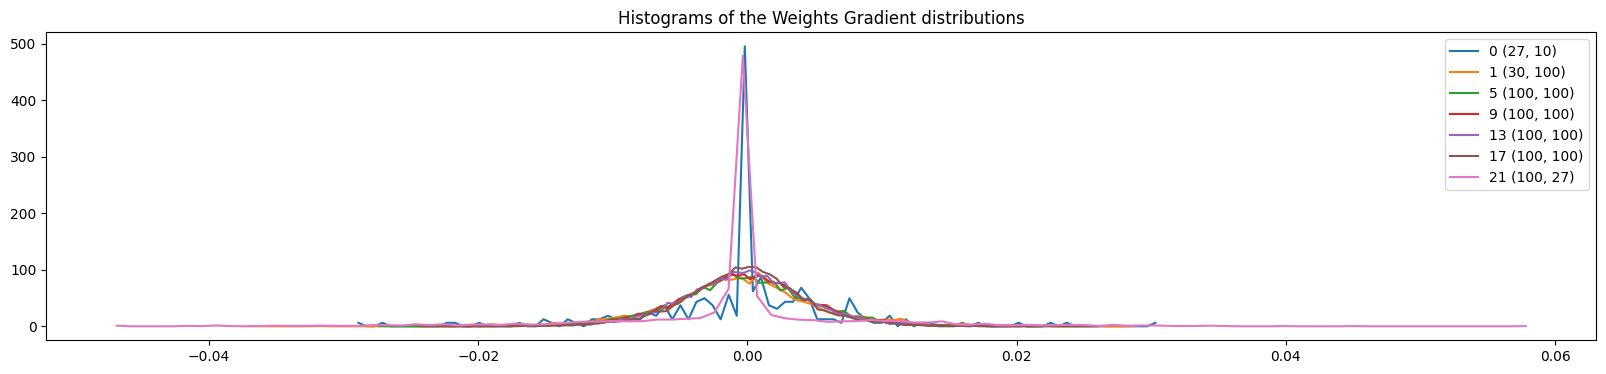

In [29]:
# Visualize the histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Histograms of the Weights Gradient distributions')

# IMPORTANT: grad:data is the scale of the gradients to the scale of the data.
# If the gradient is very high number compared to the data, it means that the gradients are exploding. Not good. 
# 'p.data += -lr * p.grad.data' will not work well. Amount of p.data will become very high if p.grad.dat is very high.
# The last layer specifically, the gradients magnitudes are very high compared to the data(see below), which is a sign of exploding gradients. SGD will not be ideal for most, best is Adam. 

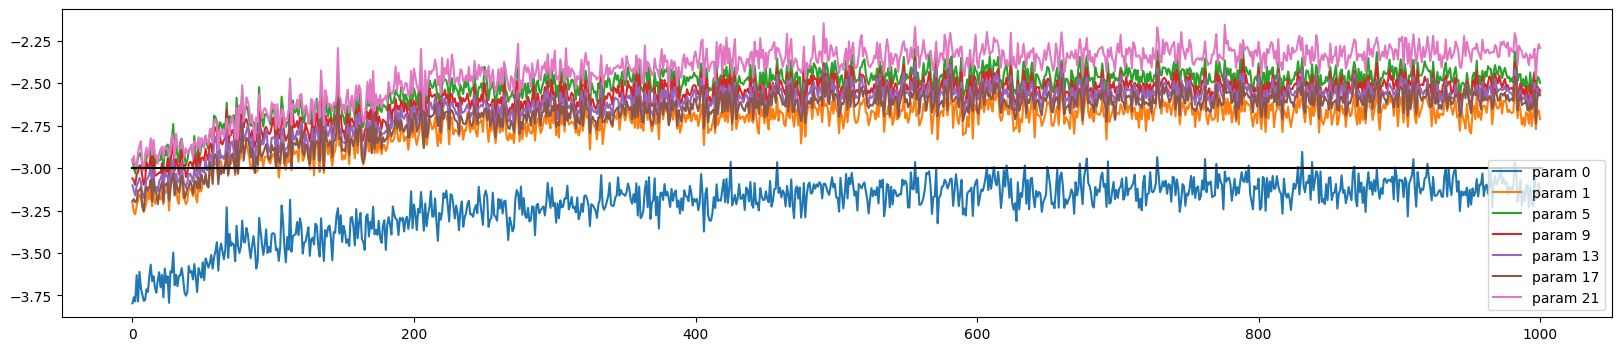

In [30]:
# let us track the update to data ratio, modified above.
# we can see from the plot that the last layer update is very high compared to the data, which is a sign of exploding gradients. 
# This mainly happend because we have kep last layer less confident.
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # -3 is the ideal value, as it means the update is 1/1000 of the data
plt.legend(legends)

In [ ]:
# Finally go ahead and add Batch normalization layers